# HW05: линейные модели и честный ML-эксперимент

Цель: построить честный baseline и сравнить его с логистической регрессией на синтетическом датасете.


## 1. Импорты


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve


## 2. Загрузка данных и первичный анализ


In [2]:
data_path = Path('S05-hw-dataset.csv')
df = pd.read_csv(data_path)

df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [3]:
# Быстрый чек на inf/NaN в числовых признаках и мягкое исправление
import warnings

num_cols = df.select_dtypes(include=[np.number]).columns
inf_count = np.isinf(df[num_cols]).sum().sum()
nan_count = df[num_cols].isna().sum().sum()
print(f'Numeric inf count: {inf_count}, NaN count: {nan_count}')

if inf_count > 0:
    df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

feature_cols = [c for c in df.columns if c != 'default']
medians = df[feature_cols].median(numeric_only=True)
df[feature_cols] = df[feature_cols].fillna(medians)

if inf_count == 0 and nan_count == 0:
    warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')


Numeric inf count: 0, NaN count: 0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [5]:
df.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [6]:
df['default'].value_counts(normalize=True)

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

Краткие наблюдения (после запуска ячеек выше):
- датасет содержит **3000** строк и **17** столбцов (из них 1 таргет и 1 технический id);
- по `describe()` явных аномалий не видно, числовые диапазоны выглядят реалистично для синтетики;
- баланс классов умеренно смещён: доля `default=1` ≈ **0.410**, `default=0` ≈ **0.590**.


## 3. Подготовка признаков и таргета


In [7]:
target_col = 'default'
drop_cols = [target_col]
if 'client_id' in df.columns:
    drop_cols.append('client_id')

X = df.drop(columns=drop_cols)
y = df[target_col]

X.head()

,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years
0,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8
1,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7
2,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5
3,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7
4,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10


## 4. Train/Test-сплит и бейзлайн


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train, y_train)

dummy_pred = dummy.predict(X_test)
dummy_proba = dummy.predict_proba(X_test)[:, 1]

dummy_acc = accuracy_score(y_test, dummy_pred)
dummy_auc = roc_auc_score(y_test, dummy_proba)

dummy_acc, dummy_auc

(0.5133333333333333, np.float64(0.5007578889348215))

## 5. Логистическая регрессия и подбор гиперпараметров


In [9]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0],
}

search = GridSearchCV(pipe, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=1)
search.fit(X_train, y_train)

search.best_params_, search.best_score_

({'logreg__C': 10.0}, np.float64(0.8606805259098491))

In [10]:
best_model = search.best_estimator_

logreg_pred = best_model.predict(X_test)
logreg_proba = best_model.predict_proba(X_test)[:, 1]

logreg_acc = accuracy_score(y_test, logreg_pred)
logreg_auc = roc_auc_score(y_test, logreg_proba)

logreg_acc, logreg_auc

(0.8, np.float64(0.875660282026549))

## 6. Сравнение моделей и ROC-кривая


In [11]:
results = pd.DataFrame([
    {'model': 'DummyClassifier', 'accuracy': dummy_acc, 'roc_auc': dummy_auc},
    {'model': 'LogisticRegression', 'accuracy': logreg_acc, 'roc_auc': logreg_auc},
])

results

,model,accuracy,roc_auc
0,DummyClassifier,0.513333,0.500758
1,LogisticRegression,0.800000,0.875660


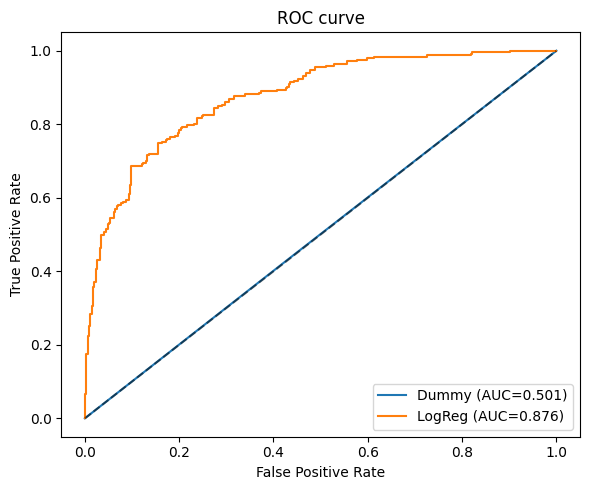

PosixPath('figures/roc_curve.png')

In [12]:
fpr_d, tpr_d, _ = roc_curve(y_test, dummy_proba)
fpr_l, tpr_l, _ = roc_curve(y_test, logreg_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr_d, tpr_d, label=f'Dummy (AUC={dummy_auc:.3f})')
plt.plot(fpr_l, tpr_l, label=f'LogReg (AUC={logreg_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.tight_layout()

figures_dir = Path('figures')
figures_dir.mkdir(exist_ok=True)
fig_path = figures_dir / 'roc_curve.png'
plt.savefig(fig_path, dpi=120)
plt.show()

fig_path

## 7. Выводы

Итоговые выводы (после запуска всех ячеек):

1. Бейзлайн `DummyClassifier` даёт качество около **accuracy=0.513** и **ROC-AUC=0.501**, то есть близко к случайному угадыванию.
2. Логистическая регрессия заметно лучше: **accuracy=0.800**, **ROC-AUC=0.876**, прирост по обеим метрикам существенный.
3. Лучшее значение регуляризации в сетке — **C=10.0**, более сильная регуляризация давала худший ROC-AUC.
4. Разница между моделями показывает, что признаки действительно информативны, а линейная модель их использует.
5. Для задачи бинарного дефолта логистическая регрессия выглядит разумным и интерпретируемым выбором.
6. Результаты воспроизводимы за счёт фиксированного `random_state` и стратифицированного сплита.
